In [1]:
import os, librosa, librosa.display, matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import scipy.io.wavfile as wav

TRAIN_DIR = '/Users/joeschlessinger/Programming/trainTrackER/recordings/train'
NOT_TRAIN_DIR = '/Users/joeschlessinger/Programming/trainTrackER/recordings/not_train'
CLASSIFIED_TRAIN_DIR = '/Users/joeschlessinger/Programming/trainTrackER/recordings/classified_trains'


# Visualizing the Sounds

In [2]:
def format_filename(filename):
    # 'train_horn_20240326_115843.wav' turn this into DTG
    dtg = filename[filename.find('train_horn_')+11:-4]
    dt = datetime.strptime(dtg, '%Y%m%d_%H%M%S')
    return dt.strftime('%-I:%M %d%b').upper()  # %-I for hour without leading zero


In [3]:
def plot_waveform(filename):
    y, sr = librosa.load(file, sr=None)
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.title(format_filename(file))

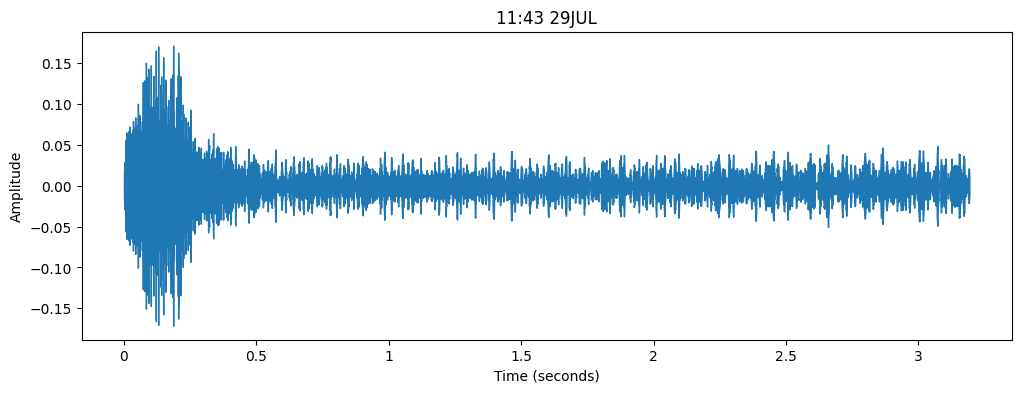

In [4]:
file = os.path.join(TRAIN_DIR, os.listdir(TRAIN_DIR)[0])
plot_waveform(file)
plt.savefig("./figures/train_timedomain.png")

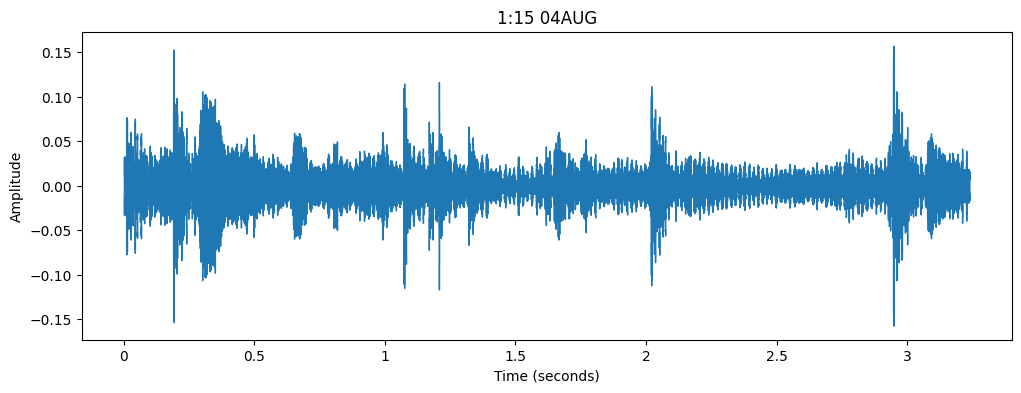

In [5]:
file = os.path.join(NOT_TRAIN_DIR, os.listdir(NOT_TRAIN_DIR)[0])
plot_waveform(file)
plt.savefig("./figures/not_train_timedomain.png")

In [18]:
def fft(filename):
    try: 
        sample_rate, data = wav.read(filename)
    except ValueError: 
        return
    fft_result = np.fft.fft(data)
    
    # Calculate the frequency bins
    freq_bins = np.fft.fftfreq(len(fft_result), 1/sample_rate)
    # Take only the positive frequencies (first half of the spectrum)
    positive_freq_bins = freq_bins[:len(freq_bins)//2]
    # Take the absolute value of the FFT result to get the magnitude spectrum
    magnitude_spectrum = np.abs(fft_result[:len(fft_result)//2])
    
    # Plot the spectrum
    plt.plot(positive_freq_bins, magnitude_spectrum)
    plt.title(format_filename(filename))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid()
    plt.xlim(0, 500)
    # plt.show()

In [6]:
for file in [os.path.join(TRAIN_DIR, f) for f in os.listdir(TRAIN_DIR)]:
     fft(file) 
plt.title("Train Frequency Decomposition")
plt.xlim(0, 1000)
#plt.savefig("./figures/train_freqdomain.png")

NameError: name 'fft' is not defined

(0.0, 1000.0)

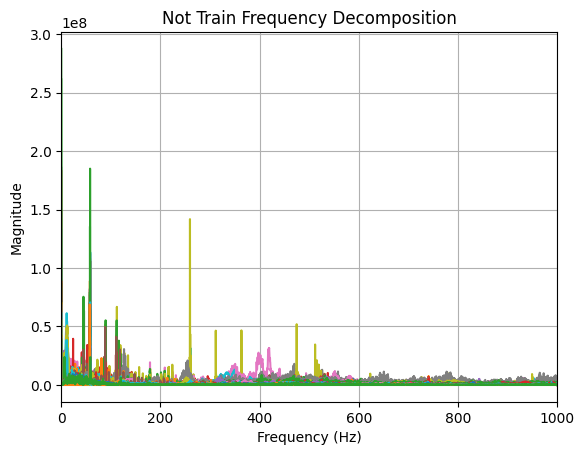

In [184]:
for i, file in enumerate([os.path.join(NOT_TRAIN_DIR, f) for f in os.listdir(NOT_TRAIN_DIR)]):
    fft(file) 
plt.title("Not Train Frequency Decomposition")
plt.xlim(0, 1000)
#plt.savefig("./figures/not_train_freqdomain.png")

# Training the Classifier

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

### Build Labelled Data Set

In [31]:
file_paths, labels = [], []
for file in [os.path.join(TRAIN_DIR, f) for f in os.listdir(TRAIN_DIR)]:
    if file.endswith(".wav"):
        file_paths.append(file)
        labels.append(1)

for file in [os.path.join(CLASSIFIED_TRAIN_DIR, f) for f in os.listdir(CLASSIFIED_TRAIN_DIR)]:
    if file.endswith(".wav"):
        file_paths.append(file)
        labels.append(1)

for file in [os.path.join(NOT_TRAIN_DIR, f) for f in os.listdir(NOT_TRAIN_DIR)]:
    if file.endswith(".wav"):
        file_paths.append(file)
        labels.append(0)

In [45]:
len(os.listdir(TRAIN_DIR))

83

In [44]:
len(os.listdir(NOT_TRAIN_DIR))

1213

In [46]:
83+1213

1296

In [33]:
len(NOT_TRAIN_DIR)

68

In [10]:
def extract_features(file_path, n_bins=10, min_freq=0, max_freq=1000):
    # takes file and outputs X for the model
    y, sr = librosa.load(file_path, sr=None)
    stft = np.abs(librosa.stft(y))
    freqs = librosa.fft_frequencies(sr=sr)
    target_freqs = freqs[(freqs >= min_freq) & (freqs <= max_freq)]
    target_stft = stft[(freqs >= min_freq) & (freqs <= max_freq)]
    bin_edges = np.linspace(target_freqs[0], target_freqs[-1], n_bins + 1)
    mean_features = []
    std_features = []
    for i in range(n_bins):
        bin_mask = (target_freqs >= bin_edges[i]) & (target_freqs < bin_edges[i + 1])
        bin_stft = target_stft[bin_mask]
        mean_features.append(np.mean(bin_stft))
        std_features.append(np.std(bin_stft))
    features = np.hstack([mean_features, std_features])
    return features


In [11]:
class CustomFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins=10, min_freq=0, max_freq=1000):
        self.n_bins = n_bins
        self.min_freq = min_freq
        self.max_freq = max_freq

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([extract_features(fp, self.n_bins, self.min_freq, self.max_freq) for fp in X])

In [12]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class CustomFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins=10, min_freq=0, max_freq=1000):
        self.n_bins = n_bins
        self.min_freq = min_freq
        self.max_freq = max_freq

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([extract_features(fp, self.n_bins, self.min_freq, self.max_freq) for fp in X])

    def get_params(self, deep=True):
        return {
            'n_bins': self.n_bins,
            'min_freq': self.min_freq,
            'max_freq': self.max_freq
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


In [13]:
X = np.array([extract_features(fp) for fp in file_paths])
y = np.array(labels)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Function to classify new audio samples
def classify_audio(file_path, model, scaler):
    features = extract_features(file_path)
    features = scaler.transform([features])
    prediction = model.predict(features)
    return prediction[0]

Accuracy: 0.9471698113207547
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       243
           1       0.72      0.59      0.65        22

    accuracy                           0.95       265
   macro avg       0.84      0.79      0.81       265
weighted avg       0.94      0.95      0.94       265



In [14]:
# Split the data into training and test sets
X_train_paths, X_test_paths, y_train, y_test = train_test_split(file_paths, labels, test_size=0.1, random_state=42)

# Create the pipeline
pipe = Pipeline([
    ('feature_extractor', CustomFeatureExtractor()),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

param_grid = {
    'feature_extractor__n_bins': [10, 20],
    'feature_extractor__min_freq': [300,400],
    'feature_extractor__max_freq': [700,800]
}

grid_search = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(n_splits=2), verbose=1)

grid_search.fit(X_train_paths, y_train)

print("Best parameters found: ", grid_search.best_params_)

y_pred = grid_search.best_estimator_.predict(X_test_paths)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Function to classify new audio samples using the best estimator
def classify_audio(file_path, model):
    return model.predict([file_path])[0]

Fitting 2 folds for each of 8 candidates, totalling 16 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in divide
  ret 

KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define your custom feature extractor here
class CustomFeatureExtractor:
    # Your implementation here
    pass

# Split the data into training and test sets
X_train_paths, X_test_paths, y_train, y_test = train_test_split(file_paths, labels, test_size=0.1, random_state=42)

# Create the pipeline
pipe = Pipeline([
    ('feature_extractor', CustomFeatureExtractor()),
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(max_iter=500, random_state=42))
])

param_grid = {
    'feature_extractor__n_bins': [10, 20],
    'feature_extractor__min_freq': [300, 400],
    'feature_extractor__max_freq': [700, 800],
    'classifier__hidden_layer_sizes': [(50, 50), (100,)],
    'classifier__alpha': [0.0001, 0.001]
}

grid_search = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(n_splits=2), verbose=1)

grid_search.fit(X_train_paths, y_train)

print("Best parameters found: ", grid_search.best_params_)

y_pred = grid_search.best_estimator_.predict(X_test_paths)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Function to classify new audio samples using the best estimator
def classify_audio(file_path, model):
    return model.predict([file_path])[0]

# Wrong Predictions and Interpeting Model

In [1]:
import fit_model, main, joblib

In [2]:
from fit_model import CustomFeatureExtractor

In [3]:
model = joblib.load("./best_model_with_length.pkl")

In [29]:
fit_model.train_model_explicit(30, 250, 950)#, confusion="./figures/conf_matrix.png")
                               # file_name="./best_model_with_length.pkl", save=True)

Accuracy: 0.9884169884169884
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       240
           1       0.94      0.89      0.92        19

    accuracy                           0.99       259
   macro avg       0.97      0.95      0.96       259
weighted avg       0.99      0.99      0.99       259



In [17]:
model

Pipeline(steps=[('feature_extractor',
                 CustomFeatureExtractor(max_freq=950, min_freq=400, n_bins=20)),
                ('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

In [25]:
len(model.named_steps['classifier'].feature_importances_)

41

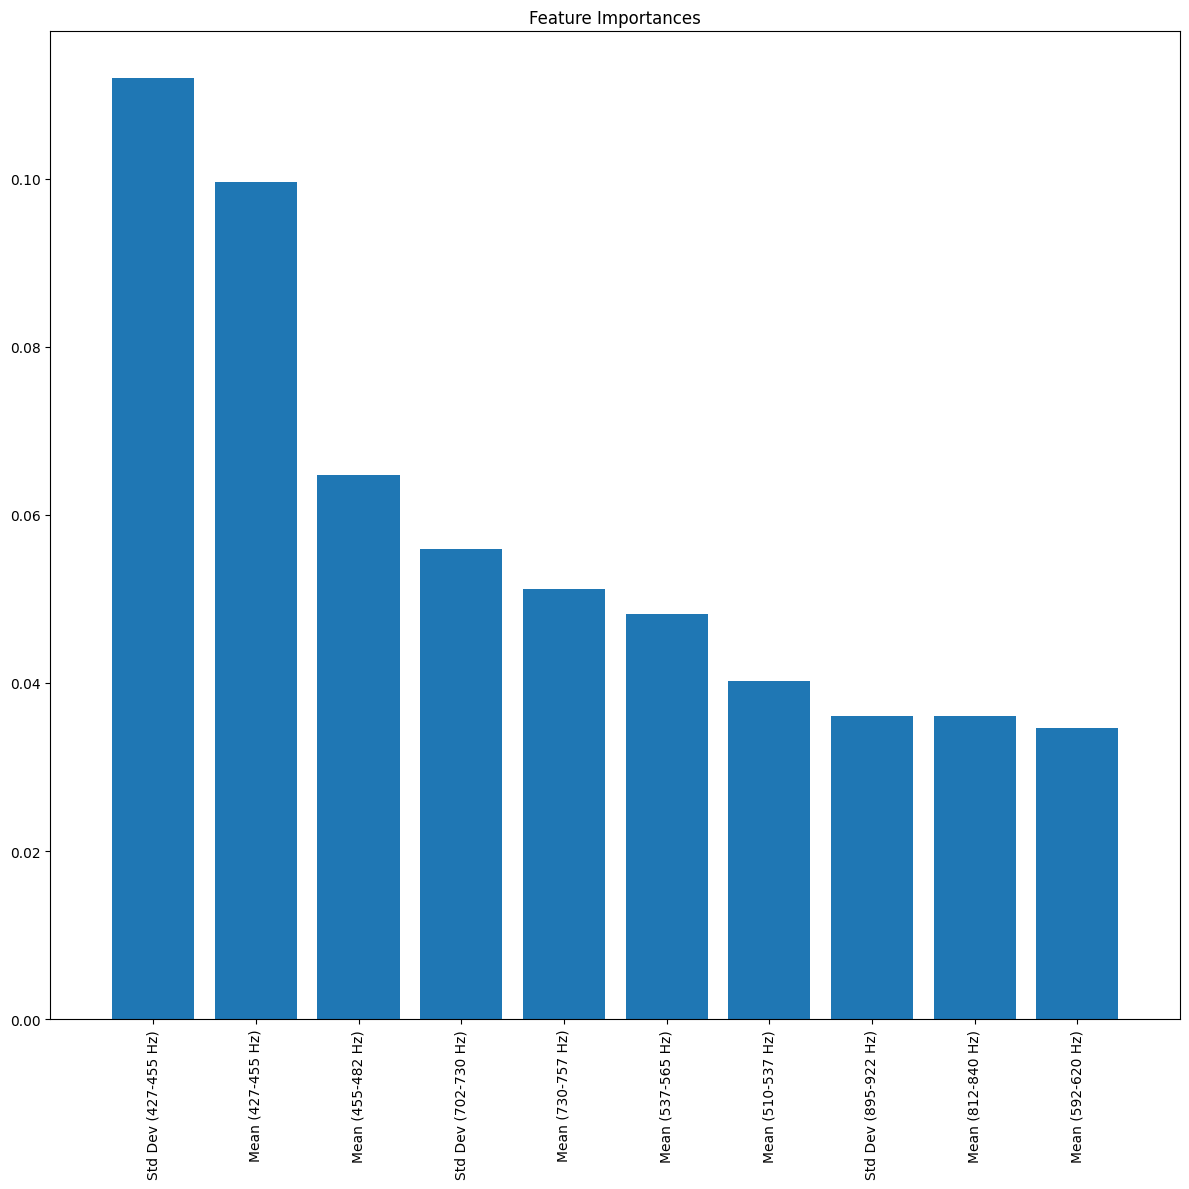

In [26]:
def generate_feature_labels(n_bins, min_freq, max_freq):
    bin_edges = np.linspace(min_freq, max_freq, n_bins + 1)
    feature_labels = []

    for i in range(n_bins):
        freq_range = f"{int(bin_edges[i])}-{int(bin_edges[i + 1])} Hz"
        feature_labels.append(f"Mean ({freq_range})")
        feature_labels.append(f"Std Dev ({freq_range})")
    
    feature_labels.append("Peak Length")
    
    return feature_labels

def plot_feature_importances_from_pipeline(pipeline, feature_labels, n_features=None):
    """
    Plots the feature importances from a classifier within a pipeline.

    :param pipeline: The trained sklearn pipeline.
    :param feature_labels: List of feature labels corresponding to the features used in the model.
    """
    # Access the classifier from the pipeline
    classifier = pipeline.named_steps['classifier']
    importances = classifier.feature_importances_
    indices = np.argsort(importances)[::-1]

    if n_features:
        importance_len = n_features
        indices = indices[:n_features]       
    else:
        importance_len = len(importances)
    plt.figure(figsize=(12, 12))
    plt.title("Feature Importances")
    plt.bar(range(importance_len), importances[indices], align="center")
    plt.xticks(range(importance_len), [feature_labels[i] for i in indices], rotation=90)
    plt.xlim([-1, importance_len])
    plt.tight_layout()
    plt.savefig("./figures/feature_importances.png")

best_pipeline = joblib.load('./best_model_with_length.pkl')

n_bins = 20
min_freq = 400
max_freq = 950
feature_labels = generate_feature_labels(n_bins, min_freq, max_freq)

plot_feature_importances_from_pipeline(best_pipeline, feature_labels, n_features=10)

In [32]:
file.split("/")[-1].strip(".wav") + ".png"

'train_horn_20240817_162051.png'

In [22]:
for file in [os.path.join(NOT_TRAIN_DIR, f) for f in os.listdir(NOT_TRAIN_DIR)]:
    if file.endswith(".wav") and main.classify_audio(file, model) != 0:
        plot_waveform(file)
        plt.show()
        print(file)
        fft(file)
        plt.savefig(file.split("/")[-1].strip(".wav") + ".png")

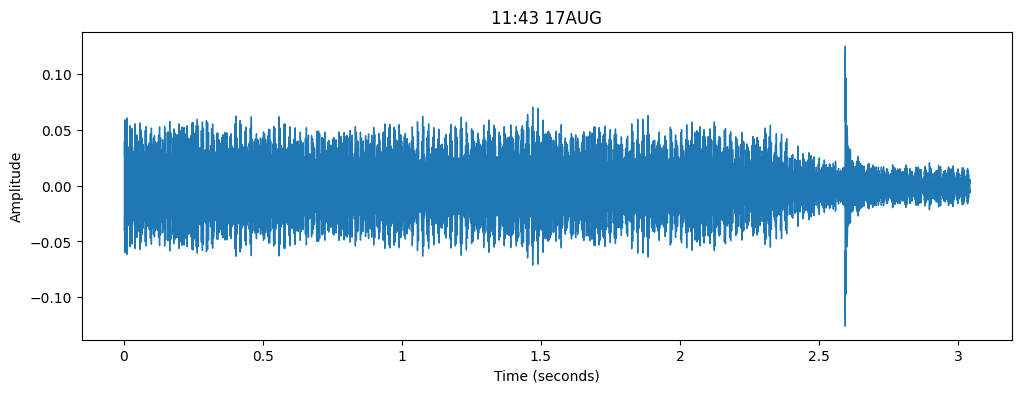

/Users/joeschlessinger/Programming/trainTrackER/recordings/train/train_horn_20240817_114349.wav
./figures/train_horn_20240817_114349.png


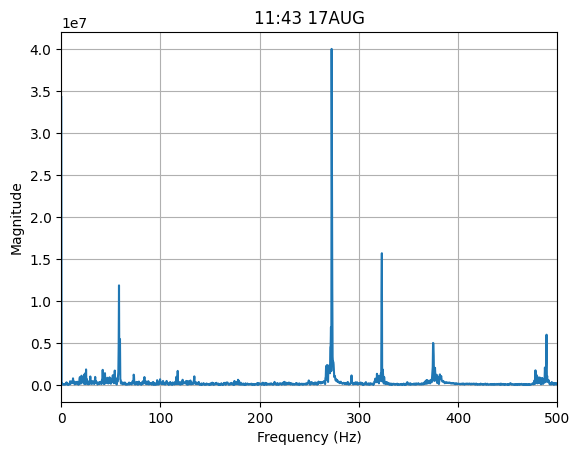

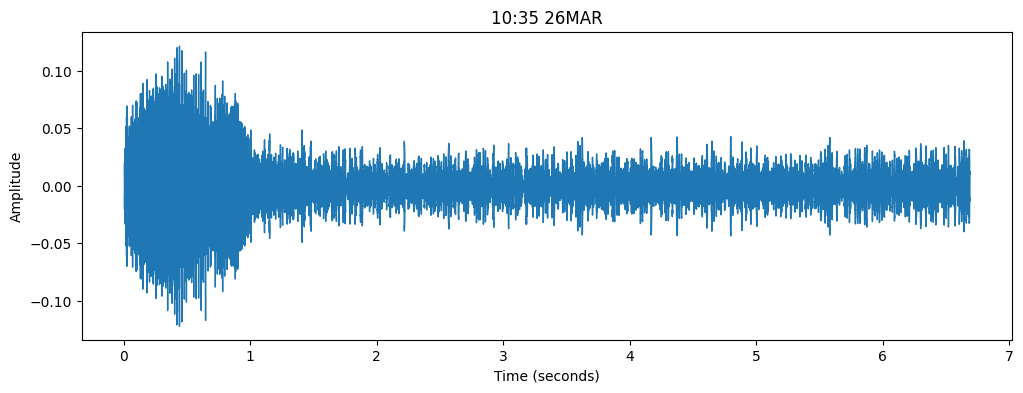

/Users/joeschlessinger/Programming/trainTrackER/recordings/train/train_horn_20240326_223518.wav
./figures/train_horn_20240326_223518.png


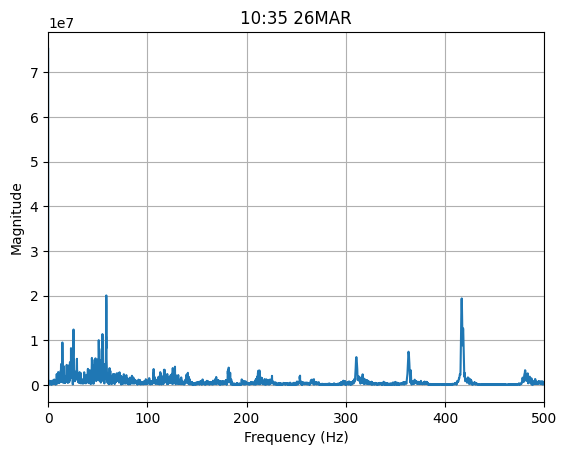

In [34]:
for file in [os.path.join(TRAIN_DIR, f) for f in os.listdir(TRAIN_DIR)]:
    if file.endswith(".wav") and main.classify_audio(file, model) != 1:
        plot_waveform(file)
        plt.show()
        print(file)
        fft(file)
        plt.savefig("./figures/" + file.split("/")[-1].strip(".wav") + ".png")
        print("./figures/" + file.split("/")[-1].strip(".wav") + ".png")

In [26]:
def extract_features(file_path, n_bins=10, min_freq=0, max_freq=1000):
    # takes file and outputs X for the model
    y, sr = librosa.load(file_path, sr=None)
    stft = np.abs(librosa.stft(y))
    freqs = librosa.fft_frequencies(sr=sr)
    target_freqs = freqs[(freqs >= min_freq) & (freqs <= max_freq)]
    target_stft = stft[(freqs >= min_freq) & (freqs <= max_freq)]
    bin_edges = np.linspace(target_freqs[0], target_freqs[-1], n_bins + 1)
    print(bin_edges)
    mean_features = []
    std_features = []
    for i in range(n_bins):
        bin_mask = (target_freqs >= bin_edges[i]) & (target_freqs < bin_edges[i + 1])
        bin_stft = target_stft[bin_mask]
        mean_features.append(np.mean(bin_stft))
        std_features.append(np.std(bin_stft))
    features = np.hstack([mean_features, std_features])
    return features


In [ ]:
# extract_features(file, n_bins=20, min_freq=200, max_freq=700)

In [31]:

len(os.listdir(TRAIN_DIR))

34

## Plotting Timeline

In [34]:
start = datetime(2024, 7, 28)
end = datetime(2024, 8, 3)

In [33]:
import random

datetimes = [start + (end-start)*random.random() for i in range(20)]

In [6]:
from datetime import datetime, timedelta

In [9]:
def get_times(date_range=None):
    TRAIN_DIR = '/Users/joeschlessinger/Programming/trainTrackER/recordings/train'
    CLASS_TRAIN_DIR = '/Users/joeschlessinger/Programming/trainTrackER/recordings/classified_trains'
    times = []
    for f in os.listdir(CLASS_TRAIN_DIR) + os.listdir(TRAIN_DIR):
        if f.endswith(".wav"):
            time = datetime.strptime(
                f.split('_')[2] + f.split('_')[3].split('.')[0], "%Y%m%d%H%M%S"
            )
            if date_range is None:
                times.append(time)
            elif date_range is not None and time >= date_range[0] and time <= date_range[1]:
                times.append(time)
            

    return times

In [10]:
def combine_close_events(times, minutes=5):
    times = sorted(times)
    last = times[0]
    new_times = [last]
    for t in times[1:]:
        # print(t, last+timedelta(minutes=minutes))
        if t > last + timedelta(minutes=minutes):
            new_times.append(t)
        last = t
    return new_times

In [16]:
def plot_train_sched(times):
    print(f"Plotting {len(times)} train things") 
    days = [dt.weekday() for dt in times]  # Monday is 0 and Sunday is 6
    times = [dt.time() for dt in times]
    
    times_in_seconds = [t.hour * 3600 + t.minute * 60 + t.second for t in times]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(days, times_in_seconds, c='blue', alpha=0.6)
    
    plt.title('Train Times by Day of the Week')
    plt.xlabel('Day of the Week')
    plt.ylabel('Time of the Day')
    plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    plt.yticks(ticks=range(0, 86401, 3600), labels=[f'{h}:00' for h in range(25)])
    plt.grid(True)

Plotting 239 train things


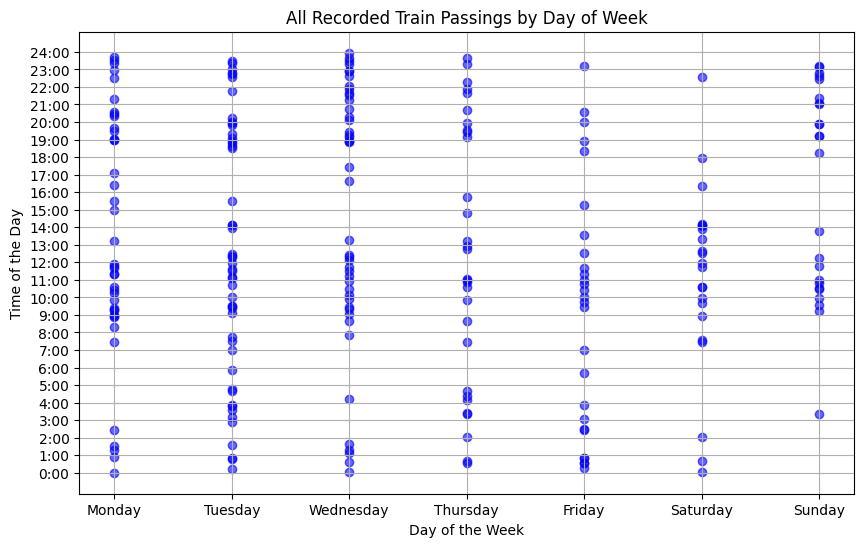

In [44]:
plot_train_sched(combine_close_events(
    get_times(date_range=None), minutes=10)
                )
plt.title("All Recorded Train Passings by Day of Week")
plt.savefig("./figures/running_train_schedule.png")

Plotting 114 train things


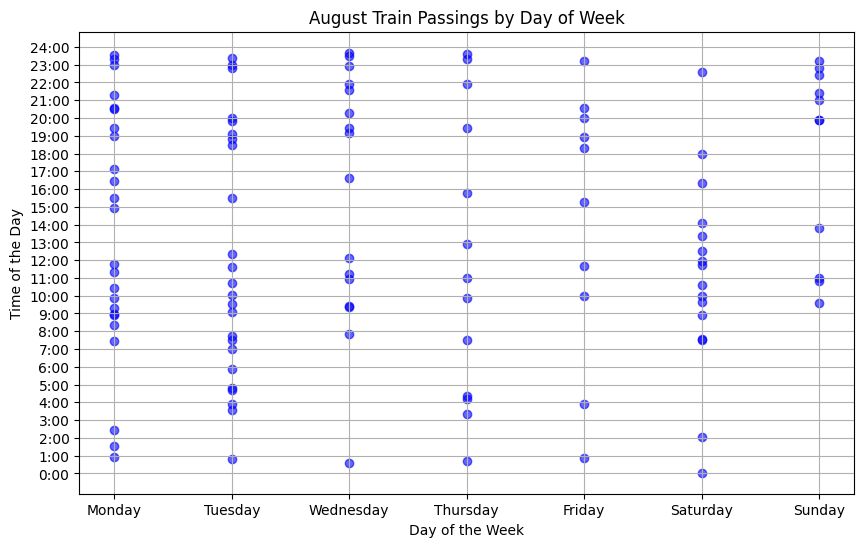

In [43]:
from datetime import timedelta
# start = datetime(2024, 8, 28, 0, 0)                  
# for i in range(5):
#     start = start + timedelta(days=7*i)
#     end = start + timedelta(days=7)
start = datetime(2024, 8, 4, 0)                  
end = datetime(2024, 9, 4, 0, 0)     
plot_train_sched(combine_close_events(
        get_times(date_range=(start,end)), minutes=10)
                )
plt.title("August Train Passings by Day of Week")
#plt.show()
plt.savefig("./figures/typical_train_schedule.png")

Plotting 115 train things


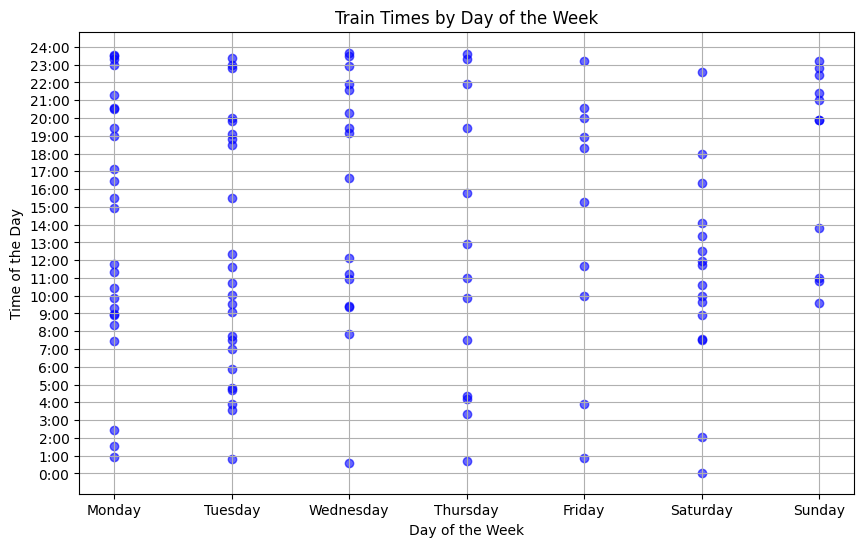

In [22]:
start = datetime(2024, 8, 4, 0, 0)                  
end = datetime(2024, 9, 4, 0, 0)                  

plot_train_sched(combine_close_events(
    get_times(date_range=(start,end)), minutes=5)
                )
#plt.savefig("./figures/typical_train_schedule.png")

In [24]:
all_trains = combine_close_events(get_times(date_range=None), minutes=10)

Average number of events per week: 26.555555555555557


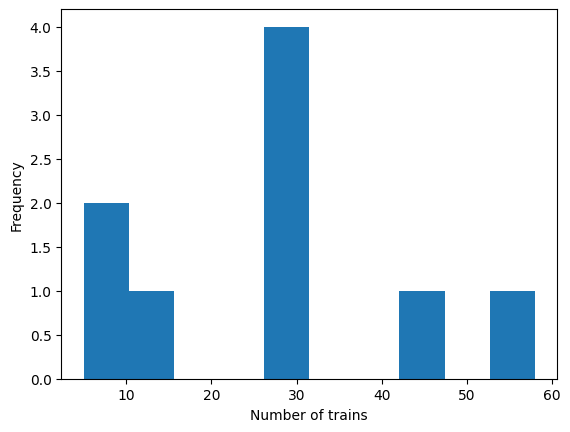

In [31]:
import pandas as pd
df = pd.DataFrame(all_trains, columns=['event_time'])
df['week'] = df['event_time'].dt.isocalendar().week  # Extract week number
weekly_counts = df.groupby('week').size()  # Count events per week

# Step 3: Calculate the average number of events per week
weekly_counts.plot(kind="hist")
plt.xlabel("Number of trains")
average_events_per_week = weekly_counts.mean()

print(f'Average number of events per week: {average_events_per_week}')

In [42]:
weekly_counts

week
13    11
31    27
32     6
33     5
34    28
35    58
36    28
37    46
38    30
dtype: int64

In [26]:
all_trains

[datetime.datetime(2024, 3, 26, 11, 58, 43),
 datetime.datetime(2024, 3, 26, 14, 6, 12),
 datetime.datetime(2024, 3, 26, 22, 35, 18),
 datetime.datetime(2024, 3, 27, 4, 12, 6),
 datetime.datetime(2024, 3, 27, 18, 56, 12),
 datetime.datetime(2024, 3, 27, 21, 16, 32),
 datetime.datetime(2024, 3, 27, 22, 39, 8),
 datetime.datetime(2024, 3, 28, 4, 41),
 datetime.datetime(2024, 3, 30, 0, 40, 27),
 datetime.datetime(2024, 3, 30, 13, 52, 36),
 datetime.datetime(2024, 3, 30, 14, 11, 9),
 datetime.datetime(2024, 7, 29, 9, 22, 32),
 datetime.datetime(2024, 7, 29, 10, 16, 40),
 datetime.datetime(2024, 7, 29, 11, 54, 18),
 datetime.datetime(2024, 7, 29, 18, 59, 21),
 datetime.datetime(2024, 7, 29, 20, 21, 39),
 datetime.datetime(2024, 7, 29, 23, 43),
 datetime.datetime(2024, 7, 30, 9, 23, 19),
 datetime.datetime(2024, 7, 30, 11, 8, 9),
 datetime.datetime(2024, 7, 30, 12, 29, 7),
 datetime.datetime(2024, 7, 30, 13, 58, 55),
 datetime.datetime(2024, 7, 30, 19, 17, 39),
 datetime.datetime(2024, 7, 31